### Baptiste Bedouret, Dimitrios Fikos
### 23/2/2024

# Home assignment

* Author: Romain Tavenard (@rtavenar)
* License: CC-BY-NC-SA

A home assignment from a course on Machine Learning for Time Series at ENSAI.
One can find lecture notes for this course [there](https://rtavenar.github.io/ml4ts_ensai/).

## Problem statement

The dataset we are interested in here is called "TwoPatterns". It is described [in this page](http://www.timeseriesclassification.com/description.php?Dataset=TwoPatterns) and can be downloaded using `tslearn`'s `load_dataset` utility, as seen in previous labs.

You should load the data and analyze it under several angles:

1. visualize the dataset (or a few time series from the dataset) to understand whether you expect time-shift-invariant methods to perform well on this dataset or not ;
2. compare time-shift-invariant methods to their time-shift-sensitive counterparts for the following tasks, and conclude:
    * clustering ;
    * supervised classification ;
    * forecasting (suppose you have to forecast the second half of the series with the first half provided as input).

It is not asked here that you implement specific layers / methods by yourself, but rather that you use established implementations of the methods you need.
Your focus should rather be on:
* data visualization,
* model architecture (for deep networks),
* experiment design,
* result analysis

## Deadline

Deadline for this home assignment is February 23th, 2024.
You should use the link on moodle to hand in your assignment.
A single ipynb file should be provided,
with execution traces.
This assignment is to be done **by groups of two, at most** and names of both students should be included in the file name.

### 0- Libraries

How to use the packages:
* execute the cell below
* execute the second one
* restart the kernel
* execute again the cell below
* don't execute the second own

In [ ]:
!pip install git+https://github.com/tslearn-team/tslearn.git@keras3
import numpy as np
import matplotlib.pyplot as plt
from tslearn.datasets import CachedDatasets
from tensorflow.keras.utils import to_categorical

  Cloning https://github.com/tslearn-team/tslearn.git (to revision keras3) to /tmp/pip-req-build-qwej2kez
  Running command git clone --filter=blob:none --quiet https://github.com/tslearn-team/tslearn.git /tmp/pip-req-build-qwej2kez
  Running command git checkout -b keras3 --track origin/keras3
  Switched to a new branch 'keras3'
  Branch 'keras3' set up to track remote branch 'keras3' from 'origin'.
  Resolved https://github.com/tslearn-team/tslearn.git to commit aecce61991026c705ecc9412da52df0e04202452
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.


### 1- Load Data

In [ ]:
from tslearn.datasets import UCR_UEA_datasets

# Load the "TwoPatterns" dataset
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset("TwoPatterns")

# Print dataset information
print("Dataset: TwoPatterns")
print("Dimension of X_train:", X_train.shape)
print("Dimension of X_test:", X_test.shape)

print("Number of classes:", np.unique(y_train))
y_train = to_categorical(y_train-1)
y_test = to_categorical(y_test -1)
print("Dimension of y_train:", y_train.shape)
print("Dimension of y_test:", y_test.shape)

Dataset: TwoPatterns
Dimension of X_train: (1000, 128, 1)
Dimension of X_test: (4000, 128, 1)
Number of classes: [1 2 3 4]
Dimension of y_train: (1000, 4)
Dimension of y_test: (4000, 4)


In [ ]:
# Seed to ensure reproducibility
np.random.seed(42)

# Shuffle the data
indices = np.random.choice(len(X_train), size = len(X_train), replace = False)
X_train = X_train[indices]
y_train = y_train[indices]
print(f"Shape of X_train: {X_train.shape} and shape of y_train: {y_train.shape}")

Shape of X_train: (1000, 128, 1) and shape of y_train: (1000, 4)


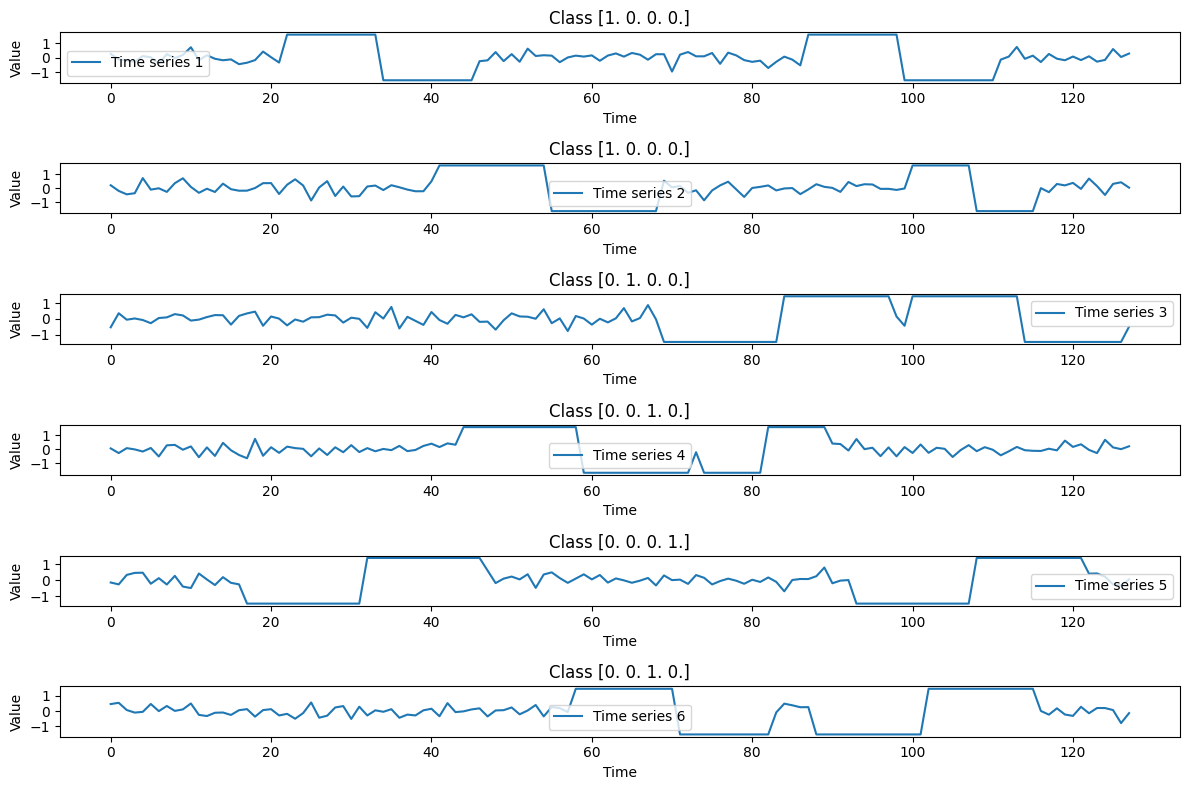

In [ ]:
# Plot a few time series
num_samples_to_plot = 6
plt.figure(figsize=(12, 8))
for i in range(num_samples_to_plot):
    plt.subplot(num_samples_to_plot, 1, i + 1)
    plt.plot(X_train[i].squeeze(), label=f"Time series {i+1}")
    plt.title((f"Class {y_train[i]}"))
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()

plt.tight_layout()
plt.show()

By visual inspection of these first 6 time series, we can see some patterns shifted in time that repeat across different time series. For example we can observe that time series 1 and 2 are quite similar because they have similar patterns (they belong to the same class). They are also generated in different timestamp. Moreover, the patterns are relatively simple and have repeating structures which could be good for time-shift-invariant methods.

### 2- k-means clustering

Using standard clustering algorithms in **part a** can cause trouble when dealing with time-shifted time series.
To counter this, in **part b** we use Dynamic Time Warping (DTW) with k-means so as to deal with time-shift-invariant. At the end, a comparison of the 2 methods is done in **part c**.

In [ ]:
from tslearn.metrics import dtw, soft_dtw
from tslearn.barycenters import dtw_barycenter_averaging, softdtw_barycenter
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

#### a- Euclidian k-means

We use a time-shift-sensitive version of the clustering algorithm using Euclidean distance.

In [ ]:
def kmeans_euclidean(X, k, max_iter=10):
    kmeans = KMeans(n_clusters=k, n_init='auto', max_iter=max_iter, random_state=0)
    assign = kmeans.fit_predict(X.reshape(X.shape[0], -1))
    centroids = kmeans.cluster_centers_.reshape(k, X.shape[1], X.shape[2])
    return assign, centroids

assign_euclidean, centroids_euclidean = kmeans_euclidean(X_train, k=4, max_iter=3)

Line 2 compute the k-means algorithm where we specified the number of clusters to create. The number of clusters to generate is 4 because the dataset 'TwoPatterns' is composed of 4 classes where the time series which belong to the same class have similar patterns with more or less some time-shift and it is the same for all the other classes.  
The second parameter is the number of times the k-means algorithm will be run with different centroid seeds. We specified also the maximum number of iterations for each run of the k-means algorithm.
At the end, we return the cluster assignments for each time series (assign) and the centroids of the clusters obtained from the k-means clustering.

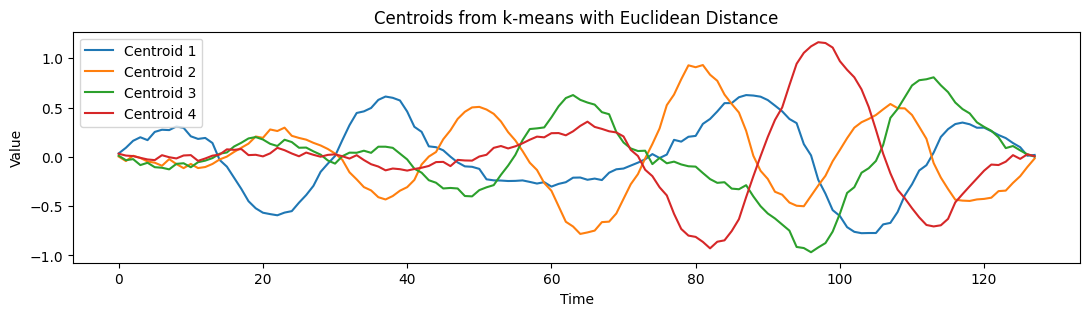

In [ ]:
plt.figure(figsize=(13, 3))
for i, centroid in enumerate(centroids_euclidean):
    plt.plot(centroid[:, 0], label=f'Centroid {i+1}')

plt.title('Centroids from k-means with Euclidean Distance')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

This plot shows the 4 centroids computed from the algorithm above. Each centroid represents a cluster center, and we can observe some patterns associated with each cluster. The centroids are well-separated in the plot, however we can't deduce which centroids belong to what class.

In [ ]:
def euclidean_cost(X, assign, centroids):
    total_cost = 0.
    for k in range(len(centroids)):
        for Xi in X[assign == k]:
            total_cost += np.sum((Xi - centroids[k])**2)
    return total_cost

#### b- Lloyd's algorithm for a k-means that use DTW as its base metric.

In [ ]:
def kmeans_dtw(X, k, max_iter=10):
    n_timeseries, n_timestamps, n_features = X.shape

    # Init barycenters at random
    barycenters = X[np.random.randint(n_timeseries, size=k)]

    for e in range(max_iter):
        # Assign a cluster to each time series
        assign = np.zeros((n_timeseries, ), dtype=int)
        for i in range(n_timeseries):
            distances = [dtw(X[i], bar) for bar in barycenters]
            assign[i] = np.argmin(distances)
        # Update centroids (barycenters) for each cluster
        for j in range(k):
            barycenters[j] = dtw_barycenter_averaging(X[assign == j])

    return assign, barycenters

assign, barycenters = kmeans_dtw(X_train, k = 4, max_iter=3)

Our function  implements the k-means clustering algorithm using DTW as the distance measure. It updates the centroids based on DTW barycenter averaging and reassigning the time series to the nearest centroids. The function iteratively refines the clusters until the max number of iteration is reached.

The objective is to find centroids or barycenters that represent the central tendency of a set of time series with respect to DTW. It is similar to the DTW Barycenter Averaging (DBA) algorithm.

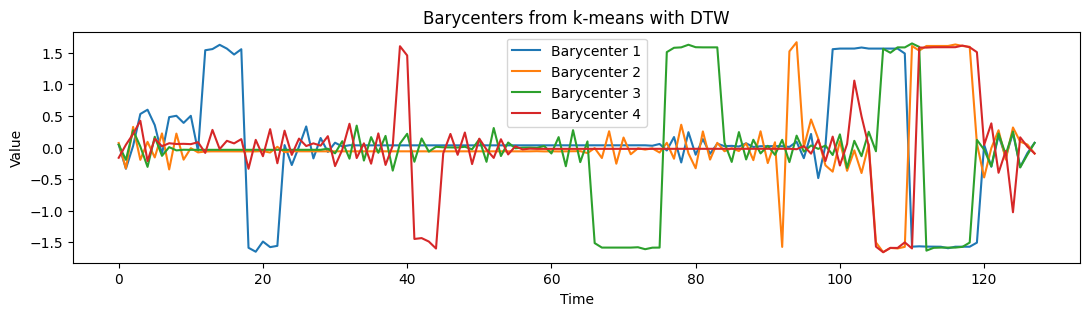

In [ ]:
plt.figure(figsize=(13, 3))
for i, bar in enumerate(barycenters):
    plt.plot(bar[:, 0], label=f'Barycenter {i+1}')

plt.title('Barycenters from k-means with DTW')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

This plot shows the 4 barycenters of the times series from the algorithm above. Compare to the plot of the centroids from k-means with Euclidian distance, in this plot we can observe that they are similar in term of shape to the time series. Unlike Euclidean distance, DTW allows for time shifts in the alignment of time series. As a result, the barycenters capture time series patterns that are invariant to time shifts.
We can see that Barycenter 3 could be the time series which belong to class 2 (up-down) because k-means gather the time series with similar characteristics in the same cluster. For example, Barycenter 1 could belong to class 1 (down-down).

In [ ]:
def dtw_cost(X, assign, barycenters):
    n_timeseries, n_timestamps, n_features = X.shape
    total_cost = 0.
    for k in range(len(barycenters)):
        for Xi in X[assign ==k]:
            total_cost += dtw(Xi, barycenters[k])**2

    return total_cost

This function assess the quality of a clustering in terms of intra-cluster inertia computed using DTW as the base metric.
For each time series in the current cluster the DTW distance between `Xi` and  the corresponding barycenter `barycenters[k]` is computed using the `dtw` function.
To resume, after iterating over all barycenters and their associated time series, the function returns the total DTW-based cost, which represents the sum of squared DTW distances between each time series and its corresponding barycenters.

#### c- Comparison between k-mean with DTW and k-mean with Euclidean distance

In [ ]:
np.random.seed(0)

assign_euclidean, centroids_euclidean = kmeans_euclidean(X_train, k = 4, max_iter=3)
cost_kmeans_euclidian = euclidean_cost(X_train, assign_euclidean, centroids_euclidean)
print("Shape of assign_euclidian", assign_euclidean.shape)
print("Shape of centroids_euclidean", centroids_euclidean.shape)
print("Cost of the Euclidean k-means:", cost_kmeans_euclidian)

np.random.seed(0)

assign, barycenters = kmeans_dtw(X_train, k = 4, max_iter=3)
cost_kmeans_dtw = dtw_cost(X_train, assign, barycenters)
print("Shape of assign", assign.shape)
print("Shape of barycenters", barycenters.shape)
print("Cost of the DTW kmeans", cost_kmeans_dtw)

Shape of assign_euclidian (1000,)
Shape of centroids_euclidean (4, 128, 1)
Cost of the Euclidean k-means: 107222.31156721777
Shape of assign (1000,)
Shape of barycenters (4, 128, 1)
Cost of the DTW kmeans 8486.097274312553


The cost of clustering represents the error of the clustering solution. Lower values indicate better clustering performance. So we can conclude from the scores obtained that the cost of the DTW k-means is lower than the cost from the euclidian k-means. It means that the lower cost of the DTW-based clustering suggests that it performs better. It is logical because DTW is more suitable for time series data, as it accounts for temporal shifts and variations.

### 3- Forecasting

We want to compare time-shift-invariant methods to their time-shift-sensitive counterparts. Soft-DTW loss offers several advantages over traditional loss functions like Mean Squared Error (MSE) in scenarios where time shifts are prevalent. Indeed, Soft-DTW loss is more robust to time shifts in the data compared to MSE. The latter takes into account the local temporal distortions between sequences.

#### a- Forecasting using MSE as a loss

We define a model architecture with 2 dense layers and a reshape layer to reshape the output to match the input shape. We use the Adam optimizer and Mean Squared Error (MSE) loss. We want to focus on a forecasting task that would consist, given the first 64 elements of a time series, in predicting the next 64 ones.

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Reshape

model1 = Sequential([
    InputLayer(input_shape=(64, 1)),
    Reshape(target_shape=(64, )),
    Dense(256, activation='relu'),
    Dense(64, activation='linear'),
    Reshape(target_shape=(64, 1))
])

model1.compile(optimizer="adam", loss = "mse")
model1.fit(X_train[:, :64], X_train[:, 64:], epochs = 200, batch_size = 20)

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.3314
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.1580
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1158
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0955
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0994
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0606
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0310
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0043
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9987
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9792
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9805
Epoch 12/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9817
Epoch 13/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9845
Epoch 14/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9201
Epoch 15/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9228
Epoch 16/200
5

[1. 0. 0. 0.]


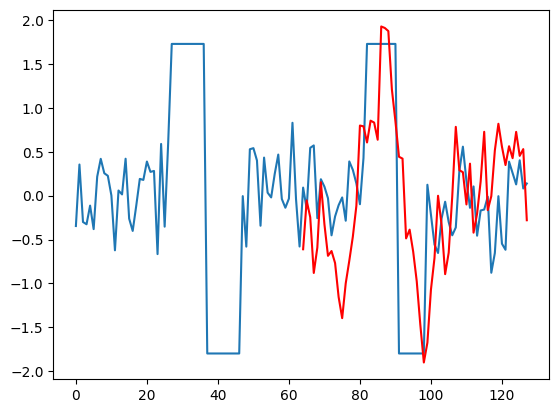

In [ ]:
import matplotlib.pyplot as plt

# Index of time series we want to visualize
ts_index = 50
y_pred = model1(X_test[:, :64, 0]).detach().cpu().data.numpy()
print(y_test[ts_index])

plt.figure()
plt.plot(X_test[ts_index].ravel())
plt.plot(np.arange(64, 128), y_pred[ts_index], 'r-')
plt.show()

In this plot the blue line represent the ground truth data, while the red line represents the predicted values by the model. The time series used here belongs to the first class (down-down). The predicted time series data has more variations (the amplitude is higher) than the blue line. In timestamp 90, we can see that the red line is shifted a bit in front compare to the blue line.
Overall, the red line follows the trend of the blue line. The model is capturing the patterns in the data and making quite good predictions.

Let's use another time series:

[0. 0. 1. 0.]


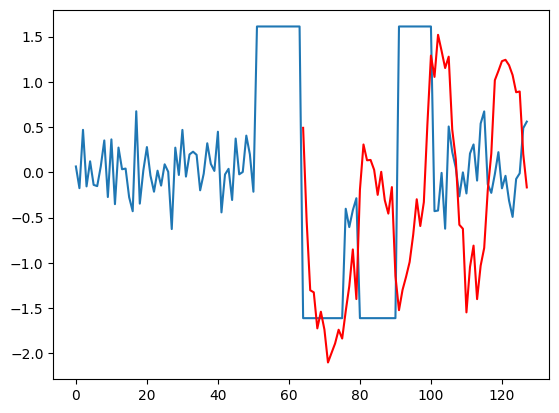

In [ ]:
# Index of time series we want to visualize
ts_index = 102
y_pred = model1(X_test[:, :64, 0]).detach().cpu().data.numpy()
print(y_test[ts_index])

plt.figure()
plt.plot(X_test[ts_index].ravel())
plt.plot(np.arange(64, 128), y_pred[ts_index], 'r-')
plt.show()

Here we can see that the predicted values of the time series are shifted in time compare to the ground truth time series. It captures the big variations (down-up) of the t.s but has more difficulties to capture the small variations.

#### b- Forecasting using Soft-DTW as a loss

Soft-DTW is differentiable with respect to its inputs. This is especially useful for forecasting tasks in which prediction is to be made for multiple time steps. Indeed, in this context, soft-DTW can be used in place of a standard Mean Squared Error (MSE) loss in order to better take time shifts into account.

We use normalized soft-DTW as a criterion to be optimized. We will train our network for 200 epochs on a forecasting task that would consist, given the first 64 elements of a time series, in predicting the next 64 ones.

In [ ]:
from tslearn.metrics import SoftDTWLossPyTorch

model2 = Sequential([
    InputLayer(input_shape=(64, 1)),
    Reshape(target_shape=(64, )),
    Dense(256, activation='relu'),
    Dense(64, activation='linear'),
    Reshape(target_shape=(64, 1))
])

loss = SoftDTWLossPyTorch(gamma=.1, normalize= True) # Soft-DTW as a loss function
model2.compile(optimizer="sgd", loss = loss)
model2.fit(X_train[:, :64], X_train[:, 64:], epochs = 200, batch_size = 20)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 28.7695
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 15.5874
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 13.6741
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 12.4840
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 12.1177
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 11.5416
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 10.9691
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 11.0756
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 10.8925
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 10.9194
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 10.5424
Epoch 12/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 10.4722
Epoch 13/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 10.2942
Epoch 14/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 10.1155
Epoch 15/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 

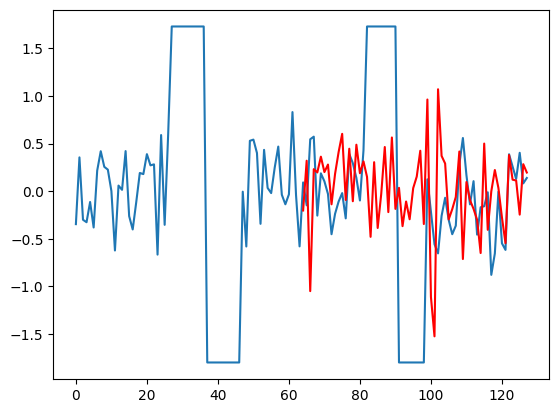

In [ ]:
# Index of time series we want to visualize
ts_index = 50
y_pred = model2(X_test[:, :64, 0]).detach().cpu().data.numpy()

plt.figure()
plt.plot(X_test[ts_index].ravel())
plt.plot(np.arange(64, 128), y_pred[ts_index], 'r-')
plt.show()

In the plot above, we could see that the red line (predicted values) doesn't seem to follow the blue line (time series) even when the time series exhibiting an upward trend followed by a downward trend.

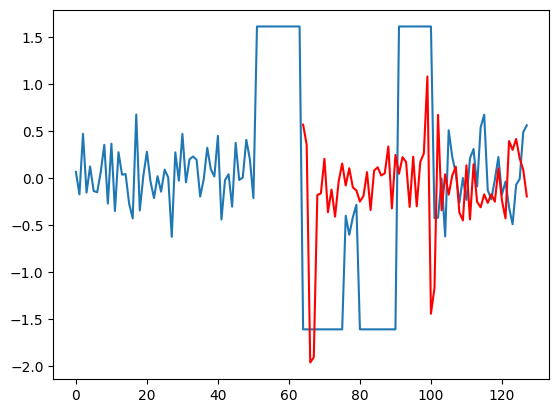

In [ ]:
# Index of time series we want to visualize
ts_index = 102
y_pred = model2(X_test[:, :64, 0]).detach().cpu().data.numpy()

plt.figure()
plt.plot(X_test[ts_index].ravel())
plt.plot(np.arange(64, 128), y_pred[ts_index], 'r-')
plt.show()

In this plot, the red line seems to match a bit with the blue line in t = 65, but after that, it doesn't capture the pattern of the time series.

#### c- Comparison

On the first hand, **part a** contains plots which use a model trained using MSE loss. On the other hand, **part b** contains plots using a model trained by using Soft-DTW loss. If we compare both plots, the plots generated from the model trained with MSE loss have better predictions that match the original time series compared to the plots generated from the model trained with Soft-DTW loss. It suggests that the MSE loss might be more effective in training the model that captures the patterns in the time series.

Soft-DTW loss effectiveness depends on the characteristics of the data. The latter is often used in forecasting when the data exhibits complex nonlinear and non-stationary patterns. Here the data might not exhibit such complex patterns.


### 4- Classification

For Supervised Classification part there is going to be a comparison between Convolutional, Recurrent neural networks and an architecture that consists of convolutional and self-attention layers. In the end we want to retrieve information about how effectively or not, these methods are for classifying the time series of this dataset.   

#### a- Convolutional Neural Networks

CNN's can be applied to time series tasks because they can operate on the sequential nature of the data by treating the time dimension as spatial dimension.

We will use One Dimensional Convolutions which are capturing local patterns or features at different positions. Three different models will be tested having one, two and three one dimensional convolutions.  

Before, proceeding we need to reload the data and shuffle them again for avoiding potential error issues.

In [ ]:
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset("TwoPatterns")
np.random.seed(42)
y_train -= 1
y_test -= 1

# Shuffle the data
indices = np.random.choice(len(X_train), size = len(X_train), replace = False)
X_train = X_train[indices]
y_train = y_train[indices]

Some key facts about the models:
* use of activation function 'relu' for all Convolutional layers
* use of max pooling layers for reducing computational complexity of the feature maps generated by convolutional layers.
* a dense layer with "softmax" activation function used for multiclassification tasks.
* "sparse categorical crossentropy" as a loss function during training
* "adam" as an optimizer during training


125/125 [==============================] - 0s 2ms/step - loss: 0.3851 - accuracy: 0.8415
Conv_1layer [0.3851035237312317, 0.8414999842643738]
125/125 [==============================] - 0s 3ms/step - loss: 0.0916 - accuracy: 0.9700
Conv_2layers [0.09160516411066055, 0.9700000286102295]
125/125 [==============================] - 0s 3ms/step - loss: 0.0153 - accuracy: 0.9958
Conv_3layers [0.015279791317880154, 0.9957500100135803]


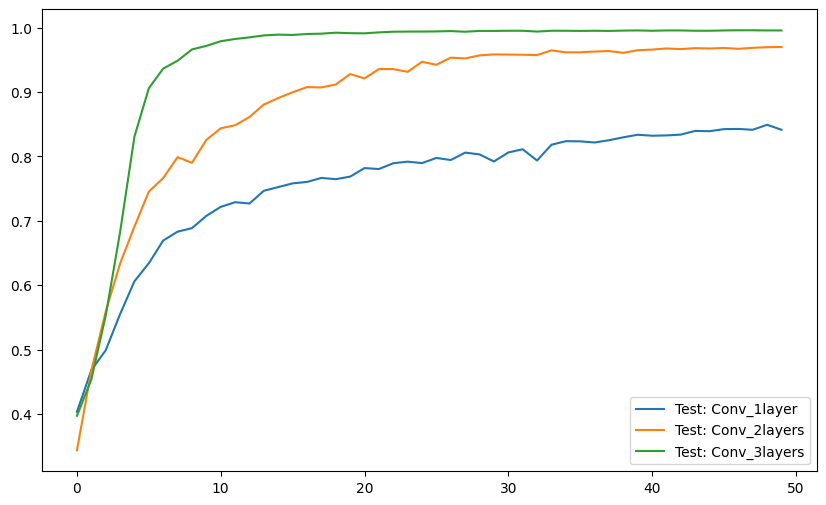

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, Flatten, Dense
from keras.callbacks import EarlyStopping

np.random.seed(42)

feature_extractors = {
    "Conv_1layer": Sequential([
         Conv1D(filters=10, kernel_size=3, activation="relu"),
         MaxPool1D(pool_size=2),
         Flatten(),
         Dense(units=4, activation="softmax")
    ]),
    "Conv_2layers": Sequential([
        Conv1D(filters=10, kernel_size=3, activation="relu"),
        MaxPool1D(pool_size=2),
        Conv1D(filters=20, kernel_size=3, activation="relu"),
        MaxPool1D(pool_size=2),
        Flatten(),
        Dense(units=4, activation="softmax")
    ]),
    "Conv_3layers": Sequential([
        Conv1D(filters=10, kernel_size=3, activation="relu"),
        MaxPool1D(pool_size=2),
        Conv1D(filters=20, kernel_size=3, activation="relu"),
        MaxPool1D(pool_size=2),
        Conv1D(filters=20, kernel_size=3, activation="relu"),
        MaxPool1D(pool_size=2),
        Flatten(),
        Dense(units=4, activation="softmax"),
    ]),
}
plt.figure(figsize=(10, 6))
for name, f in feature_extractors.items():
    model = Sequential([
        f
    ])
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    h = model.fit(X_train, y_train, epochs=50,validation_data=(X_test, y_test), verbose=False)
    print(name, model.evaluate(X_test, y_test))
    #plt.plot(h.history["accuracy"], label=f"Train: {name}")
    plt.plot(h.history["val_accuracy"], label=f"Test: {name}")
    plt.legend();

The plot shows the accuracy of the test set of each model, after training them to a total number of 50 epochs.  
We can detect that we had better accuracy for the model with three convolutional layers.
Generally all three models have good results in terms of accuracy but the third one especially shows high accuracy levels (above 90%) from a low number of epochs.
However, for this dataset maybe using only two convolutions it is also sufficient for classification tasks.   
















#### b- Recurrent Neural Networks

RNN's are designed to process sequential data like time series by maintaining an internal state also know as 'memory'. In time series they can capture different classes based on temporal patterns of data.

Two different architectures will be compared: Long Short Term Memory (LSTM) and Gated Recurrent Unit (GRU).


LSTM layer is used for capturing long term dependencies in sequential data. We will use this layer with 100 units so as to process time series and extract relevant information for classification.

In [ ]:
from keras.layers import LSTM
from keras.utils import to_categorical
# encode target labels to categorical format
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

model = Sequential([
    LSTM(units=100),
    Dense(units=4, activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=50)
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print('Test Accuracy:', accuracy)

Epoch 1/50
32/32 [==============================] - 8s 72ms/step - loss: 1.1109 - accuracy: 0.4660 - val_loss: 0.8352 - val_accuracy: 0.5095
Epoch 2/50
32/32 [==============================] - 1s 36ms/step - loss: 0.7429 - accuracy: 0.5540 - val_loss: 0.7023 - val_accuracy: 0.5635
Epoch 3/50
32/32 [==============================] - 1s 37ms/step - loss: 0.7058 - accuracy: 0.6140 - val_loss: 0.6478 - val_accuracy: 0.6610
Epoch 4/50
32/32 [==============================] - 1s 30ms/step - loss: 0.7481 - accuracy: 0.5300 - val_loss: 0.6766 - val_accuracy: 0.6540
Epoch 5/50
32/32 [==============================] - 2s 59ms/step - loss: 0.6601 - accuracy: 0.6800 - val_loss: 0.6243 - val_accuracy: 0.7660
Epoch 6/50
32/32 [==============================] - 2s 58ms/step - loss: 0.5054 - accuracy: 0.8120 - val_loss: 0.3828 - val_accuracy: 0.8635
Epoch 7/50
32/32 [==============================] - 1s 21ms/step - loss: 0.2788 - accuracy: 0.9220 - val_loss: 0.2231 - val_accuracy: 0.9287
Epoch 8/50
32

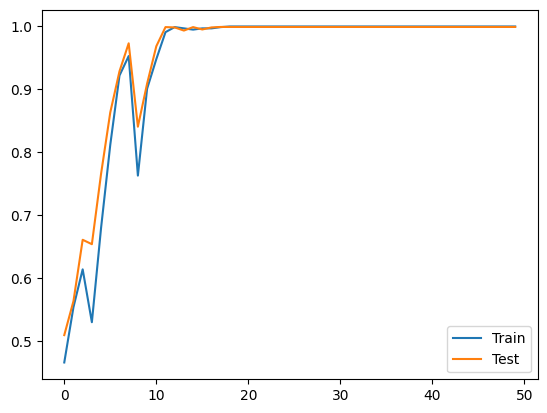

In [ ]:
plt.plot(h.history["accuracy"], label="Train")
plt.plot(h.history["val_accuracy"], label="Test")
plt.legend();

For LSTM layer we can detect its ability to classify the time series with accuracy for the test set that reaches 100% even from a small number of training epochs (after 10, looking at the plot).

GRU layer is simpler method than LSTM in terms of computations and parameters used

In [ ]:
from keras.layers import GRU

model = Sequential([
    GRU(units=100, return_sequences=True),
    Flatten(),
    Dense(units=4, activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=50)
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print('Test Accuracy:', accuracy)

Epoch 1/50
32/32 [==============================] - 4s 37ms/step - loss: 0.9523 - accuracy: 0.5620 - val_loss: 0.5942 - val_accuracy: 0.7573
Epoch 2/50
32/32 [==============================] - 1s 24ms/step - loss: 0.5022 - accuracy: 0.7890 - val_loss: 0.5032 - val_accuracy: 0.7922
Epoch 3/50
32/32 [==============================] - 1s 29ms/step - loss: 0.4388 - accuracy: 0.8110 - val_loss: 0.4467 - val_accuracy: 0.8192
Epoch 4/50
32/32 [==============================] - 1s 29ms/step - loss: 0.4195 - accuracy: 0.8220 - val_loss: 0.4191 - val_accuracy: 0.8322
Epoch 5/50
32/32 [==============================] - 1s 28ms/step - loss: 0.3590 - accuracy: 0.8580 - val_loss: 0.3907 - val_accuracy: 0.8472
Epoch 6/50
32/32 [==============================] - 1s 21ms/step - loss: 0.3460 - accuracy: 0.8620 - val_loss: 0.4219 - val_accuracy: 0.8260
Epoch 7/50
32/32 [==============================] - 1s 20ms/step - loss: 0.3236 - accuracy: 0.8720 - val_loss: 0.3282 - val_accuracy: 0.8745
Epoch 8/50
32

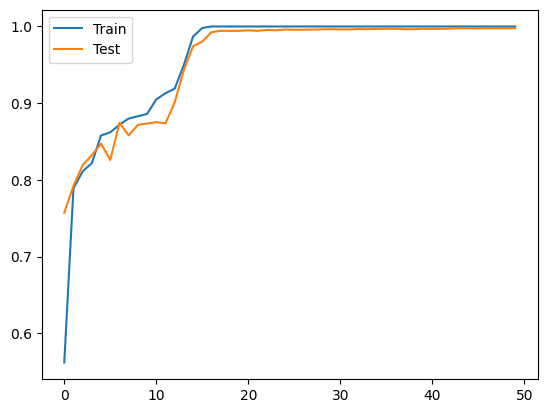

In [ ]:
plt.plot(h.history["accuracy"], label="Train")
plt.plot(h.history["val_accuracy"], label="Test")
plt.legend();

Results of GRU layer are also excellent for classifying the time series.
Compared to LSTM the computation was faster but it required some more epochs (starting approximately from 15th) to provide accuracy close to 100%.

All in all both two methods seem to be appropriate for the classification task of this dataset.

#### c- Self Attention Layer in CNN

Here we are going to use again a convolutional layer but this time we added a multihead self attention layer to the Neural Network. This mechanism is time shift invariant and gives us the chance to compare them with time shift sensitive methods as CNN and RNN.


In [ ]:
import numpy as np
from tslearn.datasets import UCR_UEA_datasets

X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset("TwoPatterns")
np.random.seed(42)
y_train -= 1
y_test -= 1

X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))

indices = np.random.choice(len(X), size=len(X), replace=False)
X = X[indices]
y = y[indices]

print(X.shape, y.shape)

(5000, 128, 1) (5000,)


In [ ]:
from keras.layers import MultiHeadAttention
class MultiHeadSelfAttention(MultiHeadAttention):
    def __init__(self, num_heads, key_dim, dropout=0.):
        super().__init__(num_heads, key_dim, dropout=dropout)

    def build(self, x_shape):
        return super().build(query_shape=x_shape, value_shape=x_shape)

    def compute_output_shape(self, x_shape):
        return super().compute_output_shape(query_shape=x_shape, value_shape=x_shape)

    def call(self, x, return_attention_scores=False):
        return super().call(x, x, return_attention_scores=return_attention_scores)

In [ ]:
from keras.layers import Dense, Flatten, MaxPool1D, MultiHeadAttention
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, Flatten, Dense

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation="relu"),
    MaxPool1D(pool_size=2),
    MultiHeadSelfAttention(num_heads=2, key_dim=64),
    Conv1D(filters=64, kernel_size=3, activation="relu"),
    Flatten(),
    Dense(4, activation="softmax")
])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history=model.fit(X, y, validation_split=0.2, epochs=50)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.2520 - loss: 1.3884 - val_accuracy: 0.2430 - val_loss: 1.3856
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2915 - loss: 1.3331 - val_accuracy: 0.8070 - val_loss: 0.5118
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8562 - loss: 0.3721 - val_accuracy: 0.9380 - val_loss: 0.1570
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9644 - loss: 0.0887 - val_accuracy: 0.9620 - val_loss: 0.1205
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9914 - loss: 0.0276 - val_accuracy: 0.9960 - val_loss: 0.0220
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9997 - loss: 0.0032 - val_accuracy: 0.9970 - val_loss: 0.0132
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.0896e-04 - val_accuracy: 0.9970 - val_loss: 0.0140
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.1852e-04 - val_ac

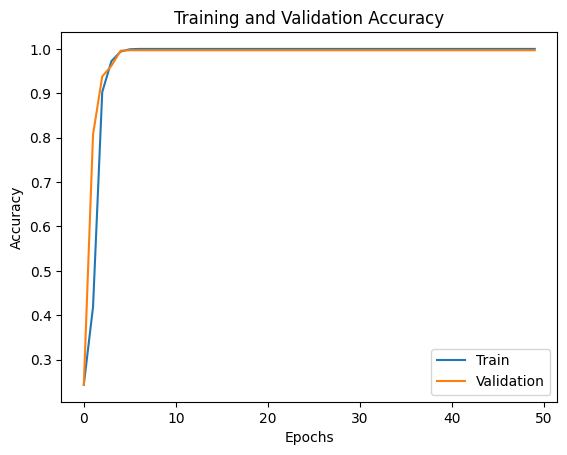

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

The combination of convolution and multihead self attention layer gave excellent results even from the first epochs of training. It seems that in these kind of a time shift invariant method brings faster and accurate classification results.

#### d- Comparison of methods used for classification

As a general comment we have to highlight the ability of all the methods to classify time series with great accuracy. It seems that classes have differences appropriate for effective classification. Among small details the attention mechanism brought the best results in terms of computational time and in terms of reaching rate close to 100% accuracy even from the 2nd or 3rd epoch.

Neural network with 3 convolutional layers was also effective although it achieved slighthly lower accuracy.

Finally, the two RNN architectures were also as accurate as the third method but they achieved it in more epochs (between 10th and 15th).
